<a href="https://colab.research.google.com/github/hafsaaaaaaaa/MLPROJECT_/blob/main/HOT_DOG1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

In [3]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

In [4]:
train_ds, valid_ds = ds["train"], ds["validation"]

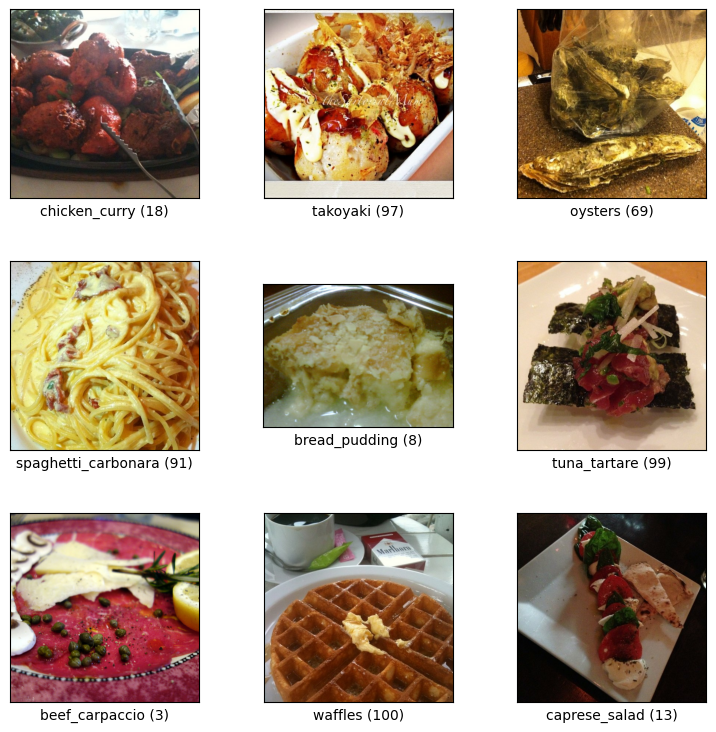

In [5]:
fig = tfds.show_examples(train_ds, ds_info)

In [6]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

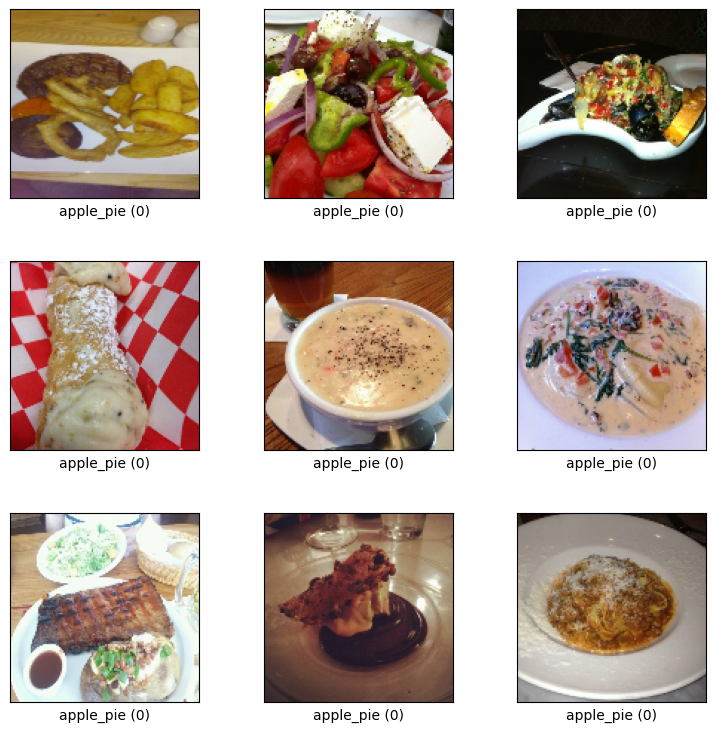

In [7]:
fig = tfds.show_examples(train_ds, ds_info)

In [8]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda _, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda _, label: label == 0)

In [9]:
valid_hotdogs = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _, label: label == 0)

In [10]:
valid_hotdogs

<_RepeatDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [11]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [12]:
for image, label in train_ds.take(3):
  print(image[0][0][0])
  print(label)

tf.Tensor([21 25 30], shape=(3,), dtype=int32)
tf.Tensor([1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1], shape=(16,), dtype=int32)
tf.Tensor([250 255 250], shape=(3,), dtype=int32)
tf.Tensor([1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1], shape=(16,), dtype=int32)
tf.Tensor([137 177 184], shape=(3,), dtype=int32)
tf.Tensor([1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1], shape=(16,), dtype=int32)


***CNN IMPLEMENTATION:***

In [13]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [14]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/50
281/281 [==============================] - 486s 2s/step - loss: 1.5397 - accuracy: 0.4998 - val_loss: 1.1960 - val_accuracy: 0.5030
Epoch 2/50
281/281 [==============================] - 9s 33ms/step - loss: 1.0242 - accuracy: 0.5051 - val_loss: 0.9079 - val_accuracy: 0.5030
Epoch 3/50
281/281 [==============================] - 9s 33ms/step - loss: 0.8380 - accuracy: 0.5351 - val_loss: 0.7878 - val_accuracy: 0.5421
Epoch 4/50
281/281 [==============================] - 9s 33ms/step - loss: 0.7608 - accuracy: 0.5587 - val_loss: 0.7386 - val_accuracy: 0.5388
Epoch 5/50
281/281 [==============================] - 9s 32ms/step - loss: 0.7199 - accuracy: 0.5727 - val_loss: 0.7116 - val_accuracy: 0.5726
Epoch 6/50
281/281 [==============================] - 9s 33ms/step - loss: 0.6961 - accuracy: 0.5903 - val_loss: 0.6901 - val_accuracy: 0.6249
Epoch 7/50
281/281 [==============================] - 9s 33ms/step - loss: 0.6776 - accuracy: 0.6014 - val_loss: 0.6778 - val_accuracy: 0.5924

In [16]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

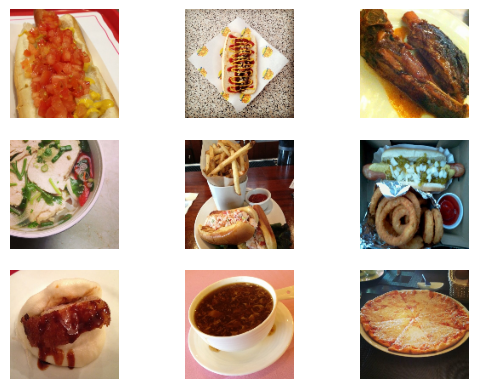

In [17]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [18]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int32)>